# CONTEXT: Working with Twitter / Language Data

##Links for today: 
* bit.ly/daaptweets
* bit.ly/tweet_colab

## Hey! I'm Erin from the DSC


... and I work on NLP research projects across disciplines.

### Some Natural Language Processing (NLP) Examples

* Classification E.G. Spam filters (or Med School Applications)
* Topic Modeling
    * [Viz Example](https://drive.google.com/file/d/1TZiLu0M9hyo090iGAXiVTN-DMh8tdUPL/view?usp=sharing)
    * [*Interactive* Viz Example](https://skpn.themlmom.com/lda/vis?method=hdsr&model=severe_acute_respiratory_syndrome_coronavirus_2-OR-covid-19-OR-sars_cov_2_q1&num_topics=15&tfidf=False&passes=20&corpus=Covid&level_select=article&dn=2,192&nodesize=docs)
    * [Published Article Ex.](https://hdsr.mitpress.mit.edu/pub/xhht1a9s/release/2)
* [Text Generation - Erin's Poetry Bot Example](https://drive.google.com/file/d/1F80qIHZsxB-FMgQP5BgYDd00rKGjPLzw/view?usp=sharing) 
    * but also - Twitter Bots / Chat Bots 
    * and - Autocomplete Text

### Today's Focus
* Supplementing other health datasets with Twitter Language Data **(1,000 Tweets!)** collected through Twitter's Search API using a python package called *Tweepy*. 

##What's an API?
**Application Programming Interface**<br>
A software intermediary that allows two applications to talk to each other. Each time you send a message, check the weather, or search on Maps - you're using an API. A lot of companies make APIs accessible to developers to open their data. 

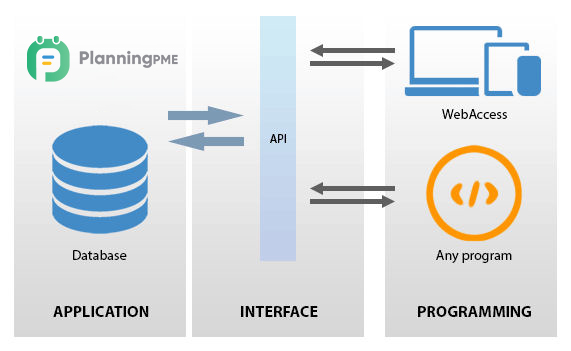

## Some Twitter Context: Pros & Cons
"Unique access to a particular aspect of the cultural landscape, of the *modern* world / new form of the historical record." <br>[(Twarc, DH@UVA)](https://dh.virginia.edu/tool/twarc)

**Exciting!**
* Explore popular movements ([e.g. #blacklivesmatter](https://www.uc.edu/news/articles/2019/08/n20848371.html))
* Survey dynamics of fast-moving socio-political events (e.g. #election2020)
* Analyze the digital footprint of contemporary culture (e.g. #instagram)

**Frustrating!**
* Functionally infinite size of the dataset 
    * Twitter has 186 million *daily, active* users and 38 million users in the United States
* Access: Access Limits, Money, and Ease
    * **PER TWITTER:** *Please note that Twitter's search service and, by extension, the Search API is not meant to be an exhaustive source of Tweets. Not all Tweets will be indexed or made available via the search interface.*
* Content:
    * All the worst parts of humans / Trolls
    * Bots (increasingly sophisticated)
    * Advertising (86% of Twitter’s revenue came from advertising in 2020)

*Read More*: [Twitter Revenue and Usage Statistics (2021)](https://www.businessofapps.com/data/twitter-statistics/)

## DATA CURATING ~~collecting~~
Sooooo ... a large part of collecting, archiving, and analyzing Twitter data involves **CURATING**. 

> INTENTION + A CRITICAL EYE

Your own Twitter archive will reflect the intention of its collector. 

* Get to know your data
* Consider the Metadata - search parameters & their potential ramifications
* Consider your search as part of an iterative process - track your decisions and make them available to your audience (transparency)



# CODE: Collecting Tweets through the Twitter API

## 1. Setting Up An Environment

First, we'll import all the Python packages we'll use for our code. Think of this like loading your toolbox (so you don't have to build a hammer). 

In [ ]:
pip install tweepy==4.4

     |████████████████████████████████| 65 kB 2.9 MB/s 
  Attempting uninstall: tweepy
    Found existing installation: tweepy 4.3.0
    Uninstalling tweepy-4.3.0:
      Successfully uninstalled tweepy-4.3.0


In [ ]:
# Import all needed libraries
from google.colab import drive
import tweepy                  
import json
import csv
import pandas as pd

Next, Google-Colab needs to connect w/your google account where we have our shared secret-credentials file stored.<br> 

The first time you run this you'll be prompted to copy a code from a separate URL and enter it below. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import json


#This line of code will open a credentials file
with open('/content/drive/My Drive/twitter_secrets.json') as f:
  secrets = json.load(f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Authentication - Accessing Twitter's API

In [ ]:
# Load Twitter API secrets from an external file

api_key = secrets['api_key']
api_secret_key = secrets['api_secret_key']
access_token = secrets['access_token']
access_token_secret = secrets['access_token_secret']
bearer_token = secrets['bearer_token']


auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)

#Api with out authorization applied and a wait enforced for reaching Twitter limits
api = tweepy.API(auth, wait_on_rate_limit=True)

# Verifying that our API credentials are working / valid
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


## 3. Selecting Parameters for a Query

In the block of code below, editing the variables will alter our output data. 

The first 3 variables are string-types and have to live between quotes.

> **terms** = 'your own word or words here'
<br>
**fromDate** = 'yyyy-mm-dd'
<br> **toDate** = 'yyyy-mm-dd'

The last variable dictates the number of tweets returned. Note: this variable-type does not use quotes.


> **count** = *This variable dictates the number of tweets in our output.* <br>START SMALL for tests & tinkering!

In [ ]:
terms = 'mental health OR pandemic'
fromDate = '2021-01-01'
toDate = '2021-12-31'


count = 5

### Mapping Data to the specific Research Question - Some Approaches: 

> If your RQ has a diachronic aspect: try running multiple queries for different timeframes using  the same terms. (e.g. "mental health" for 03/2018, 03/2019, 03/2020, 03/2021)

OR

> If your RQ is comparative: try running  the difference between overlapping groups. (e.g. mental health children / mental health adults)

OR

> If you haven't narrowed down yet, sample-querying more broadly e.g. today's Demo (to start exploring themes that arise from Tweets w/ 'mental health pandemic'

**Aim for ~1,000 Tweets in your final collection.**


## 4. Collecting Tweeets into a CSV File

The code-block below will pass our query from above to the API and loop through the results tweet by tweet. 

From each tweet, we'll collect the 5 meta/data points below & append them to a list, before outputting that to a CSV.
1. tweet_id
2. tweet itself
3. number of retweets it has
4. time of tweet
5. all the hashtags used

**NOTE**: We're limiting search to English language tweets in this demo

**TIP**: Start with a small sample size, ~5-10 tweets - you can see/adjust this later but it is good practice to make sure things are working first and to not hit Twitter's access limit right away. 

In [ ]:
# build the query using the terms/dates parameters from above
query = terms+" since:"+fromDate+" until:"+toDate
2
# Create an empty list to output tweets to
tweets = []

# Call the API w/the query & limits to the count (5 as test/set above) and language (english)
# Loop thru results to collect meta/data points from each of the tweets
for tweet in tweepy.Cursor(api.search_tweets, q=query, tweet_mode='extended', lang='en').items(count):
    t = {}
    t['tweet_id'] = tweet.id
    t['tweet'] = tweet.full_text
    t['retweet_count'] = tweet.retweet_count
    t['created_at'] = tweet.created_at
    t['author'] = tweet.user.screen_name
    t['hashtags'] = []
    for x in tweet.entities['hashtags']:
        t['hashtags'].append(x['text'])   
    tweets.append(t)
    t['full'] = tweet



# Print-check the number of tweets returned, and the 1st tweet as inspection
print ('Number of tweets collected: ', len(tweets))
print (tweets[0])

# Output the collected tweets to a CSV file
keys = tweets[0].keys()
with open('tweetsTest_111621.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(tweets)

Number of tweets collected:  5
{'tweet_id': 1468252862320820235, 'tweet': '@Kehlee_ @dobunni @dustin_ofc Males are not and never will be women. You are delusional if you believe humans can change sex. Men with mental health issues need therapy, not to be told their delusions are true.', 'retweet_count': 0, 'created_at': datetime.datetime(2021, 12, 7, 16, 15, 35, tzinfo=datetime.timezone.utc), 'author': 'WillendorfWoman', 'hashtags': [], 'full': Status(_api=<tweepy.api.API object at 0x7ff81a55b750>, _json={'created_at': 'Tue Dec 07 16:15:35 +0000 2021', 'id': 1468252862320820235, 'id_str': '1468252862320820235', 'full_text': '@Kehlee_ @dobunni @dustin_ofc Males are not and never will be women. You are delusional if you believe humans can change sex. Men with mental health issues need therapy, not to be told their delusions are true.', 'truncated': False, 'display_text_range': [30, 210], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'Kehlee_', 'name': 'Kel

Once you have the data saved to a CSV file, that file will appear in the Colab's architecture. Click on the Folder icon on the far left hand side to view it. 

**CAUTION**: you have to save that CSV file somewhere else / download it. Otherwise you can lose it once you close, reopen this Colab Notebook and have to start again. [L.o.C.K.S.S.]

## Analyzing the Output - Some Potential Questions

**TIP:** You can import your CSV files to Excel or [Google Sheets (like this one)](https://docs.google.com/spreadsheets/d/1cZ44qciiNNz6m8UOWZhjOii7sMdsepmFWeFn3QDBclg/edit?usp=sharing) and continue tinkering / analyzing / maniuplating the data there. (*Hint*: File > Import)

* What is the common vocabulary of your tweets?
* What hashtags are frequent in your dataset?
* What are the most-retweeted tweets?
* Are the tweet-time fluctuations by day or hour?
* What's the ratio of tweets / retweets?

## Hand-Tagging (what columns might you add?)
* Positive/Negative
* Other Emotions
* Is specific vocabulary present? e.g. 'isolated'
* Individual / Organization account



# HOUSEKEEPING

* **TRIPLE CHECK** that you saved your own tweets-data / download it some other place outside this Colab (L.o.C.K.S.S.)

* Access to the DSC's Twitter API credentials used in this colab will be valid through ??? 

* If you need a credentials/access extension - or just have other questions, email me: <br> 
#### Erin.McCabe@uc.edu


### Sources
* Twitter Docs / [Get your own credentials here](https://developer.twitter.com/en/portal/petition/)
* [Tweepy API Documentation](https://docs.tweepy.org/en/stable/api.html#search-tweets)
* Article: [How to build a dataset from Twitter using Python tweepy
](https://towardsdatascience.com/how-to-build-a-dataset-from-twitter-using-python-tweepy-861bdbc16fa5)